In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from PIL import Image


transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])  # for RGB
])

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        for fname in os.listdir(root_dir):
            if fname.endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(os.path.join(root_dir, fname))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloader = DataLoader(
    ImageDataset("/kaggle/input/pokemon/pokemon", transform=transform),
    batch_size=32,
    shuffle=True,
    num_workers=2
)

num_batches = len(dataloader)
print(num_batches)

26


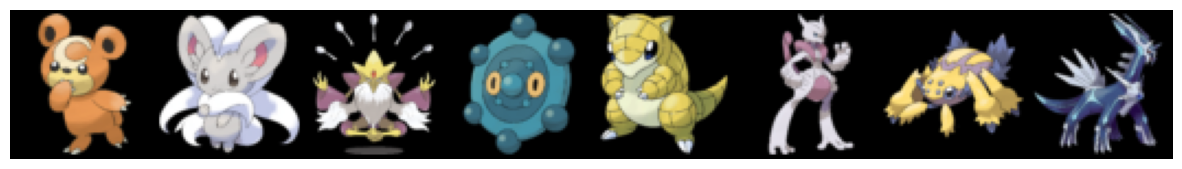

In [2]:
# Get a batch of images
data_iter = iter(dataloader)
images = next(data_iter)

# Function to display images
def show_images(images, nrow=8):
    # Denormalize the images
    images = images * 0.5 + 0.5  # Reverse the normalization
    
    # Create grid
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    
    # Convert to numpy and change dimensions for matplotlib
    grid = grid.permute(1, 2, 0).cpu().numpy()
    
    # Display
    plt.figure(figsize=(15, 15))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

# Display the batch
show_images(images[:8])

In [3]:
class Sampler:
    def __init__(self, num_training_steps=100, beta_start=0.0001, beta_end=0.002,device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        self.num_training_steps = num_training_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.beta_schedule = self.linear_beta_schedule().to(device)
        self.alpha = (1 - self.beta_schedule).to(device)
        self.alpha_cumulative_prod = torch.cumprod(self.alpha, dim=0).to(device)
        
        
    def linear_beta_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.num_training_steps)

        
    def add_noise(self, inputs, timesteps):
        batch_size, c, h, w = inputs.shape

        alpha_cumulative_prod_timesteps = self.alpha_cumulative_prod[timesteps]
        # print(alpha_cumulative_prod_timesteps)

        mean_coeff = torch.sqrt(alpha_cumulative_prod_timesteps)
        var_coeff = torch.sqrt(1 - alpha_cumulative_prod_timesteps)
        
        noise = torch.randn_like(inputs)

        mean_coeff = mean_coeff.view(-1, 1, 1, 1)
        var_coeff  = var_coeff.view(-1, 1, 1, 1)
        
        noisy_image = mean_coeff * inputs + var_coeff * noise
        # print(inputs.shape,mean_coeff.shape)
        return noisy_image, noise


    def remove_noise(self, input, timestep, predicted_noise):

        assert (input.shape == predicted_noise.shape), "Shapes of noise pattern and input image must be identical!!"
        
        b, c, h, w = input.shape

        equal_to_zero_mask = (timestep == 0) # Create mask for if timestep is 0 

        beta_t = self.beta_schedule[timestep]
        alpha_t = self.alpha[timestep]
        alpha_cumulative_prod_t = self.alpha_cumulative_prod[timestep]
        alpha_cumulative_prod_t_prev = self.alpha_cumulative_prod[timestep - 1]

        # For prev handle exception for timestep=0
        alpha_cumulative_prod_t_prev[equal_to_zero_mask] = 1.0

        noise = torch.randn_like(input)
        
        variance = beta_t * (1 - alpha_cumulative_prod_t_prev) / (1 - alpha_cumulative_prod_t)
        noise_coefficient = beta_t / (1 - alpha_cumulative_prod_t)**0.5

        variance = variance[:, None, None, None]
        noise_coefficient = noise_coefficient[:, None, None, None]
        
        sigma_t_z = noise * variance**0.5 

        reciprocal_root_a_t = alpha_t ** -0.5
        reciprocal_root_a_t = reciprocal_root_a_t[:, None, None, None]
        mean = reciprocal_root_a_t * (input - (noise_coefficient * predicted_noise))

        denoised = mean + sigma_t_z

        return denoised

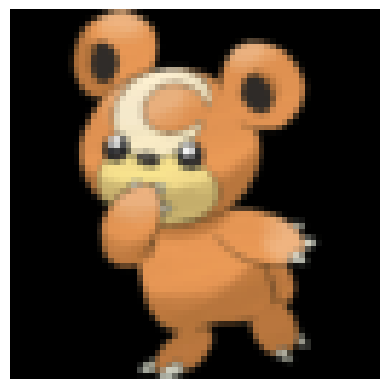

In [4]:
sampler=Sampler()
# rand=torch.randn(4,3,64,64)
# randtime=torch.randint(0,1000,(4,))
# sampler.add_noise(rand,randtime)

image = images[0]            # shape [C, H, W]
image = image * 0.5 + 0.5    # denormalize if in [-1,1]

# Convert from [C, H, W] -> [H, W, C]
img = image.permute(1, 2, 0).cpu().numpy()

plt.imshow(img)
plt.axis("off")
plt.show()


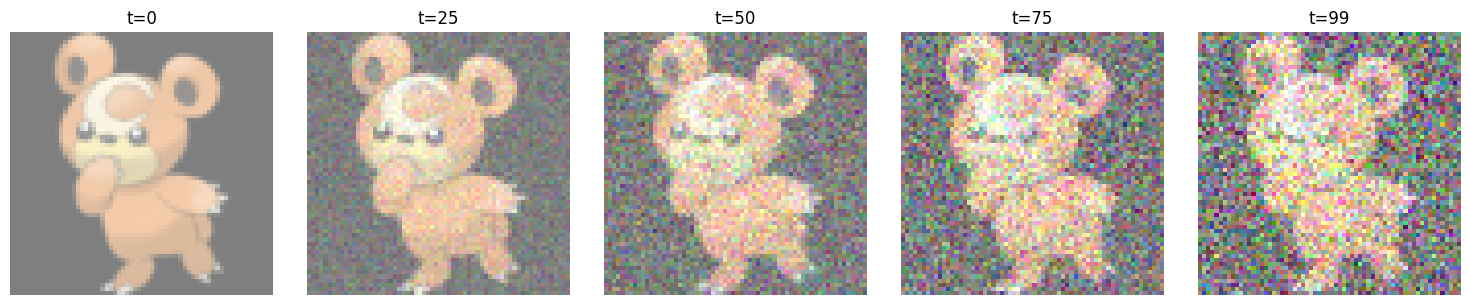

In [5]:
original_image = image.to(device)

# Visualize forward diffusion at different timesteps
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
timesteps = [0, 25, 50, 75, 99]

for i, t in enumerate(timesteps):
    if t == 0:
        img = original_image
    else:
        timestep = torch.tensor([t]).to(device)
        img, _ = sampler.add_noise(original_image.unsqueeze(0), timestep)
        img = img[0]
    
    # Denormalize for display
    img_show = (img + 1) / 2
    img_show = img_show.cpu().clamp(0, 1).permute(1, 2, 0)
    
    axes[i].imshow(img_show)
    axes[i].set_title(f't={t}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [11]:
class SelfAttention(nn.Module):

  def __init__(self, in_channels, num_heads=4, attn_p=0, proj_p=0, fused_attn=True):  # dropout = 0

    super().__init__()
    assert in_channels % num_heads == 0
    self.num_heads = num_heads
    self.head_dim = in_channels // num_heads
    self.scale = self.head_dim ** -0.5
    self.fused_attn = fused_attn  

    self.qkv = nn.Linear(in_channels, in_channels*3)
    self.attn_p = attn_p
    self.attn_drop = nn.Dropout(attn_p)
    self.proj = nn.Linear(in_channels, in_channels)
    self.proj_drop = nn.Dropout(proj_p)

  def forward(self, x):
    batch_size, seq_len, embed_dim = x.shape
      
    qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
    qkv = qkv.permute(2,0,3,1,4)
    q,k,v = qkv.unbind(0)

    if self.fused_attn:
      x = F.scaled_dot_product_attention(q,k,v, dropout_p=self.attn_p)
    else:
      attn = (q @ k.transpose(-2,-1)) * self.scale
      attn = attn.softmax(dim=-1)
      attn = self.attn_drop(attn)
      x = attn @ v
    
    x = x.transpose(1,2).reshape(batch_size, seq_len, embed_dim)
    x = self.proj(x)
    x = self.proj_drop(x)
    
    return x

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, time_embed_dim, scaled_time_embed_dim):
        super().__init__()
        self.inv_freqs = nn.Parameter(1.0 / (10000**(torch.arange(0, time_embed_dim, 2).float() / (time_embed_dim/2))), 
                                      requires_grad=False)

        # print(self.inv_freqs.shape,self.inv_freqs)
        self.time_mlp = nn.Sequential(nn.Linear(time_embed_dim, scaled_time_embed_dim), 
                                      nn.SiLU(), 
                                      nn.Linear(scaled_time_embed_dim, scaled_time_embed_dim), 
                                      nn.SiLU())
    def forward(self, timesteps):
        # print(timesteps.shape)
        timestep_freqs = timesteps.unsqueeze(1) * self.inv_freqs.unsqueeze(0)
        # print(timesteps)
        
        embeddings = torch.cat([torch.sin(timestep_freqs), torch.cos(timestep_freqs)], axis=-1)
        embeddings = self.time_mlp(embeddings)
        return embeddings

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groupnorm_num_groups, time_embed_dim):
        super().__init__()

        self.time_expand = nn.Linear(time_embed_dim, out_channels)

        self.groupnorm1 = nn.GroupNorm(groupnorm_num_groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same")

        self.groupnorm2 = nn.GroupNorm(groupnorm_num_groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same")

        self.residual_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, time_embeddings):

        residual_connection = x

        time_embed = self.time_expand(time_embeddings) 

        x = self.groupnorm1(x)
        x = self.conv1(F.silu(x))
        x = x + time_embed.reshape((*time_embed.shape, 1, 1)) # Add Time Embeddings

        x = self.groupnorm2(x)
        x = self.conv2(F.silu(x))

        x = x + self.residual_connection(residual_connection) # Add Residual 
        
        return x

class AttentionBlock(nn.Module):
    def __init__(self, in_channels, num_heads=4, attn_p=0.0, proj_p=0.0):
        super().__init__()
        self.groupnorm = nn.GroupNorm(8, in_channels)
        self.attention = SelfAttention(in_channels, num_heads, attn_p, proj_p)
        
    def forward(self, x):
        batch_size, channels, height, width = x.shape
        residual = x
        
        # Normalize and reshape for attention
        x = self.groupnorm(x)
        x = x.view(batch_size, channels, height * width).permute(0, 2, 1)  # (B, H*W, C)
        
        # Apply attention
        x = self.attention(x)
        
        # Reshape back to spatial dimensions
        x = x.permute(0, 2, 1).view(batch_size, channels, height, width)
        
        # Residual connection
        return x + residual


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groupnorm_num_groups, time_embed_dim, 
                 num_heads=4, has_attention=True, downsample=True):
        super().__init__()
        self.has_attention = has_attention
        self.downsample = downsample
        
        # ResNet blocks
        self.resnet1 = ResidualBlock(in_channels, out_channels, groupnorm_num_groups, time_embed_dim)
        self.resnet2 = ResidualBlock(out_channels, out_channels, groupnorm_num_groups, time_embed_dim)
        
        # Attention block
        if has_attention:
            self.attention = AttentionBlock(out_channels, num_heads)
        
        # Downsampling
        if downsample:
            self.downsample_conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)
    
    def forward(self, x, time_embeddings):
        # Apply ResNet blocks
        x = self.resnet1(x, time_embeddings)
        x = self.resnet2(x, time_embeddings)
        
        # Apply attention if specified
        if self.has_attention:
            x = self.attention(x)
        
        # Store skip connection before downsampling
        skip = x
        
        # Downsample if specified
        if self.downsample:
            x = self.downsample_conv(x)
        
        return x, skip


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groupnorm_num_groups, time_embed_dim, 
                 num_heads=4, has_attention=True, upsample=True):
        super().__init__()
        self.has_attention = has_attention
        self.upsample = upsample
        
        # Upsampling
        if upsample:
            self.upsample_conv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=4, stride=2, padding=1)
        
        # ResNet blocks (input channels doubled due to skip connection)
        self.resnet1 = ResidualBlock(in_channels + out_channels, out_channels, groupnorm_num_groups, time_embed_dim)
        self.resnet2 = ResidualBlock(out_channels, out_channels, groupnorm_num_groups, time_embed_dim)
        
        # Attention block
        if has_attention:
            self.attention = AttentionBlock(out_channels, num_heads)
    
    def forward(self, x, skip, time_embeddings):
        # Upsample if specified
        if self.upsample:
            x = self.upsample_conv(x)
        
        # Concatenate with skip connection
        x = torch.cat([x, skip], dim=1)
        
        # Apply ResNet blocks
        x = self.resnet1(x, time_embeddings)
        x = self.resnet2(x, time_embeddings)
        
        # Apply attention if specified
        if self.has_attention:
            x = self.attention(x)
        
        return x


class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_embed_dim=128, 
                 scaled_time_embed_dim=512, groupnorm_num_groups=8):
        super().__init__()
        
        # Time embedding
        self.time_embedding = SinusoidalTimeEmbedding(time_embed_dim, scaled_time_embed_dim)
        
        # Initial convolution
        self.initial_conv = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        
        # Encoder (Downsampling path)
        self.down1 = DownBlock(64, 128, groupnorm_num_groups, scaled_time_embed_dim, has_attention=False)
        self.down2 = DownBlock(128, 256, groupnorm_num_groups, scaled_time_embed_dim, has_attention=True)
        self.down3 = DownBlock(256, 512, groupnorm_num_groups, scaled_time_embed_dim, has_attention=True)
        
        # Bottleneck
        self.bottleneck = DownBlock(512, 512, groupnorm_num_groups, scaled_time_embed_dim, 
                                   has_attention=True, downsample=False)
        
        # Decoder (Upsampling path)
        self.up1 = UpBlock(512, 512, groupnorm_num_groups, scaled_time_embed_dim, has_attention=True)
        self.up2 = UpBlock(512, 256, groupnorm_num_groups, scaled_time_embed_dim, has_attention=True)
        self.up3 = UpBlock(256, 128, groupnorm_num_groups, scaled_time_embed_dim, has_attention=False)
        
        # Final layers
        self.final_resnet = ResidualBlock(128, 64, groupnorm_num_groups, scaled_time_embed_dim)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        
    def forward(self, x, timesteps):
        # Get time embeddings
        time_embeddings = self.time_embedding(timesteps)
        
        # Initial convolution
        x = self.initial_conv(x)
        
        # Encoder path with skip connections
        x, skip1 = self.down1(x, time_embeddings)  # 64x64 -> 32x32
        x, skip2 = self.down2(x, time_embeddings)  # 32x32 -> 16x16  
        x, skip3 = self.down3(x, time_embeddings)  # 16x16 -> 8x8
        
        # Bottleneck
        x, _ = self.bottleneck(x, time_embeddings)  # 8x8
        
        # Decoder path with skip connections
        x = self.up1(x, skip3, time_embeddings)  # 8x8 -> 16x16
        x = self.up2(x, skip2, time_embeddings)  # 16x16 -> 32x32
        x = self.up3(x, skip1, time_embeddings)  # 32x32 -> 64x64
        
        # Final processing
        x = self.final_resnet(x, time_embeddings)
        x = self.final_conv(x)
        
        return x


# Initialize the model
model = AttentionUNet(in_channels=3, out_channels=3).to(device)
sampler = Sampler()
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params/1e6}M")

56.535171M


In [18]:
del model
del optimizer
torch.cuda.empty_cache()

In [12]:
# Test the model
def test_model():
    model.eval()
    with torch.no_grad():
        # Get a batch from dataloader
        test_batch = next(iter(dataloader))
        test_images = test_batch.to(device)
        
        # Add noise
        timesteps = torch.randint(0, 100, (test_images.shape[0],)).to(device)
        noisy_images, noise = sampler.add_noise(test_images, timesteps)
        
        # Predict noise
        predicted_noise = model(noisy_images, timesteps)
        
        print(f"Input shape: {test_images.shape}")
        print(f"Noisy images shape: {noisy_images.shape}")
        print(f"Predicted noise shape: {predicted_noise.shape}")
        print(f"Actual noise shape: {noise.shape}")
        print("Model test passed!")

# Test the model
test_model()



Input shape: torch.Size([32, 3, 64, 64])
Noisy images shape: torch.Size([32, 3, 64, 64])
Predicted noise shape: torch.Size([32, 3, 64, 64])
Actual noise shape: torch.Size([32, 3, 64, 64])
Model test passed!


Starting DDPM Training...
Device: cuda
Total batches per epoch: 26
Sampling every 5 batches
--------------------------------------------------
Epoch 1/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.8419]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 29.30step/s, Step=50/50]


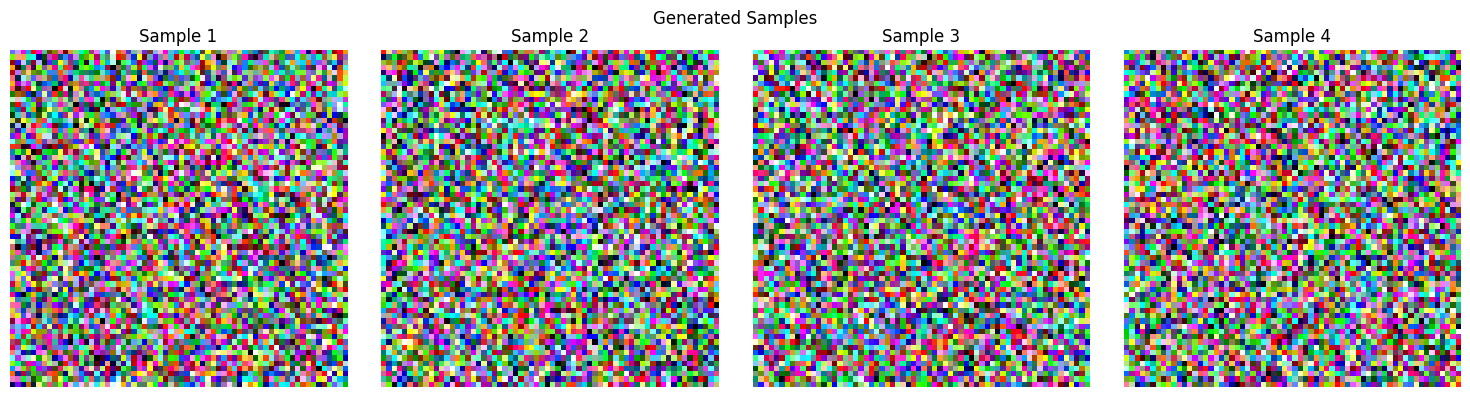

Training:  96%|█████████▌| 25/26 [00:15<00:01,  1.13s/it, Loss=0.8419]

--- Sampling complete ---



Epoch 1 completed. Average Loss: 0.9842
Epoch 2/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.2774]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.11step/s, Step=50/50]


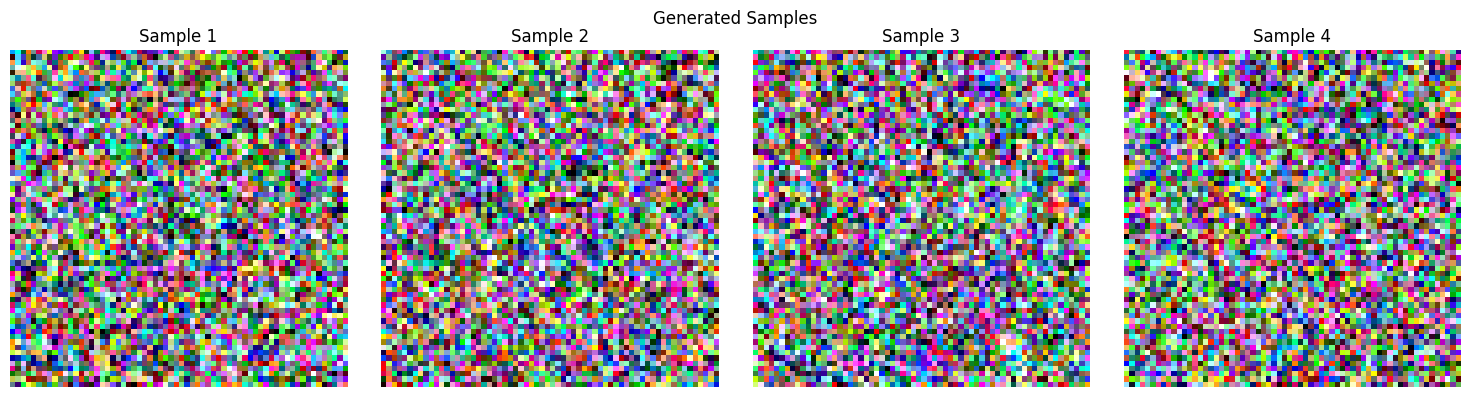

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.07s/it, Loss=0.2774]

--- Sampling complete ---



Epoch 2 completed. Average Loss: 0.4512
Epoch 3/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.2343]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.38step/s, Step=50/50]


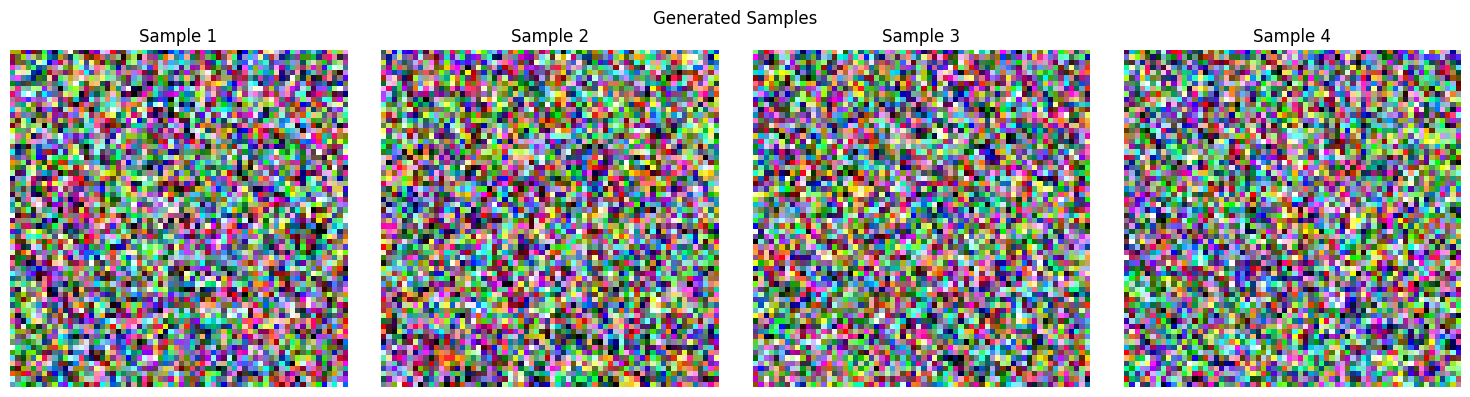

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.2343]

--- Sampling complete ---



Epoch 3 completed. Average Loss: 0.2503
Epoch 4/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.1779]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.37step/s, Step=50/50]


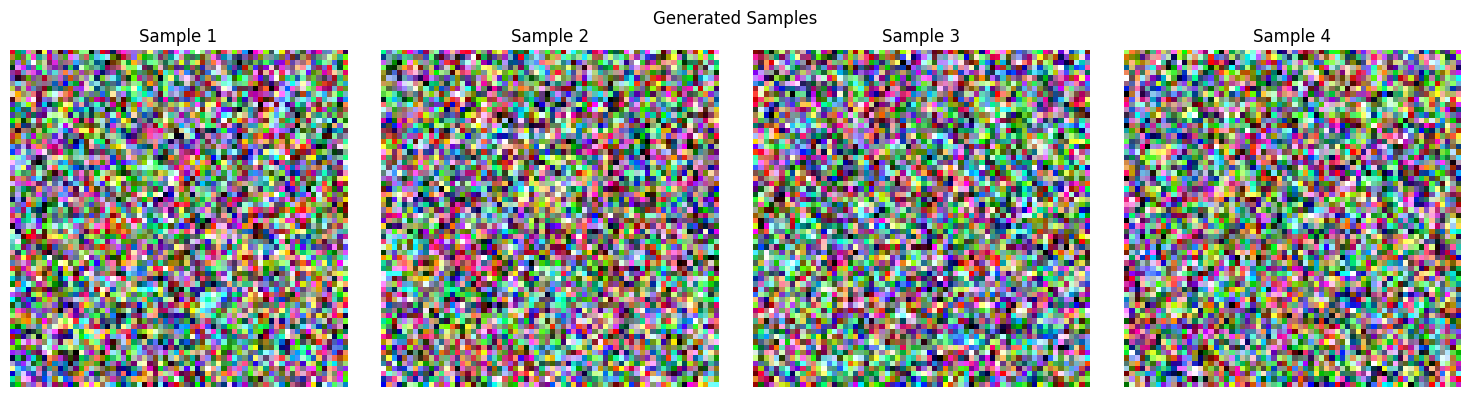

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1779]

--- Sampling complete ---



Epoch 4 completed. Average Loss: 0.2128
Epoch 5/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.2332]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.34step/s, Step=50/50]


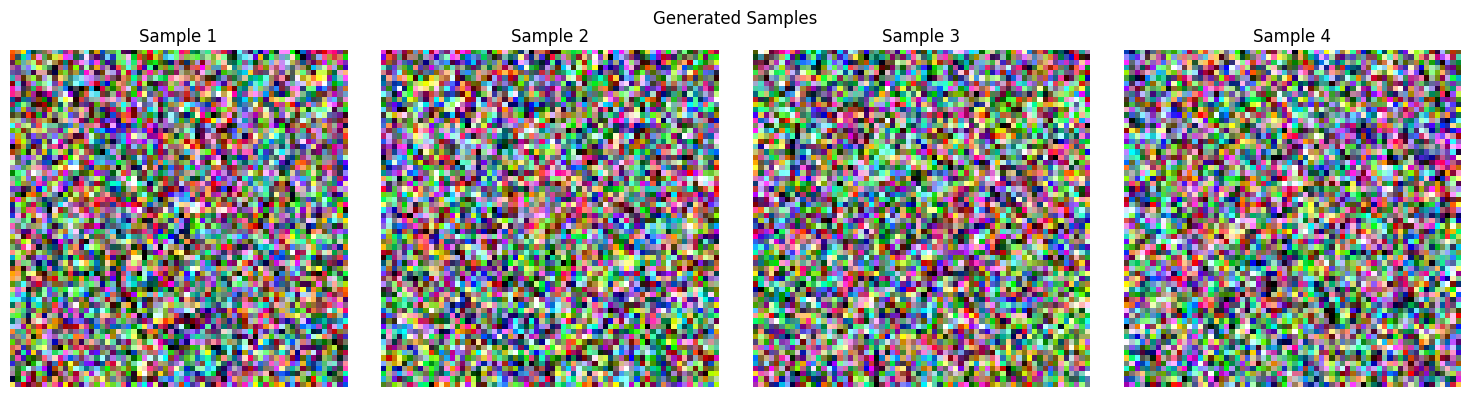

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.2332]

--- Sampling complete ---



Epoch 5 completed. Average Loss: 0.1953
Epoch 6/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.1539]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.30step/s, Step=50/50]


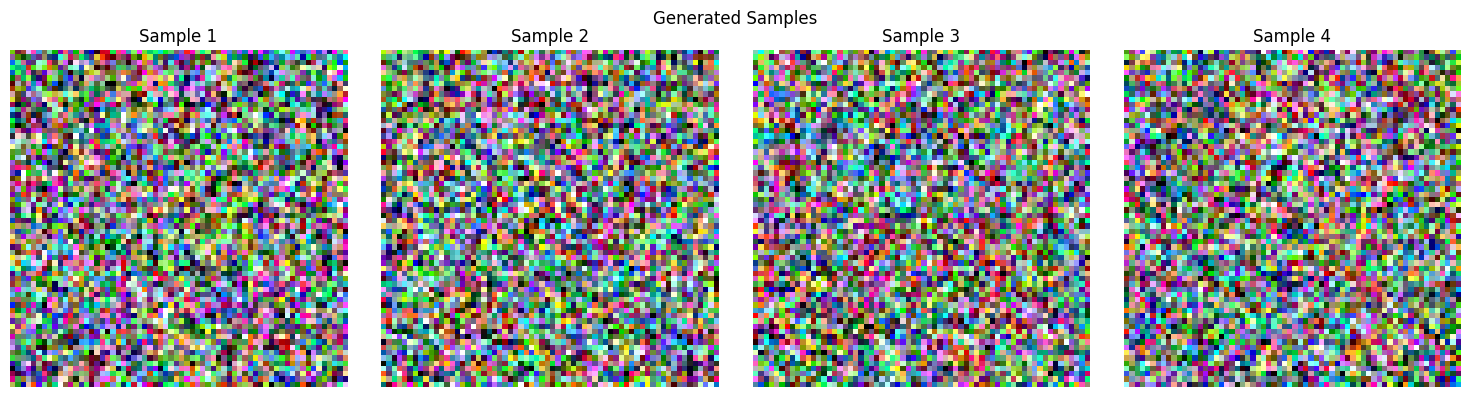

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1539]

--- Sampling complete ---



Epoch 6 completed. Average Loss: 0.1842
Epoch 7/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.91it/s, Loss=0.1404]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.28step/s, Step=50/50]


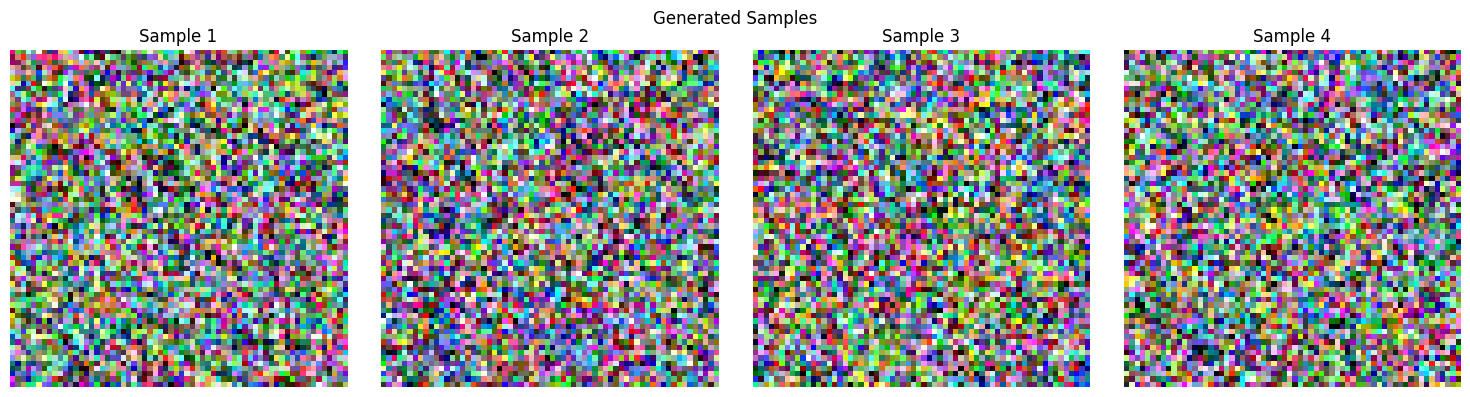

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1404]

--- Sampling complete ---



Epoch 7 completed. Average Loss: 0.1559
Epoch 8/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.1494]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.21step/s, Step=50/50]


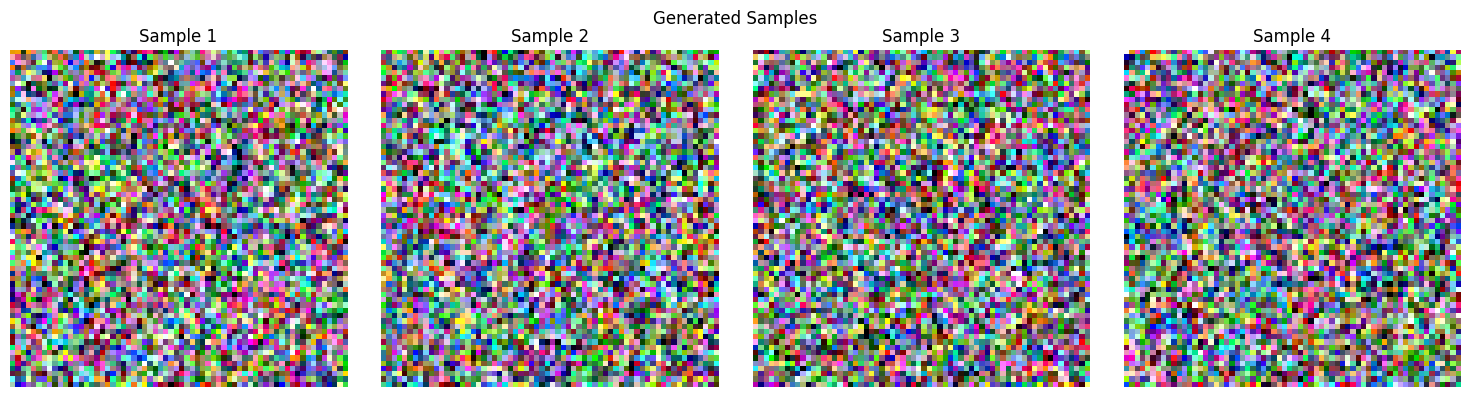

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1494]

--- Sampling complete ---



Epoch 8 completed. Average Loss: 0.1516
Epoch 9/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.91it/s, Loss=0.1521]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.30step/s, Step=50/50]


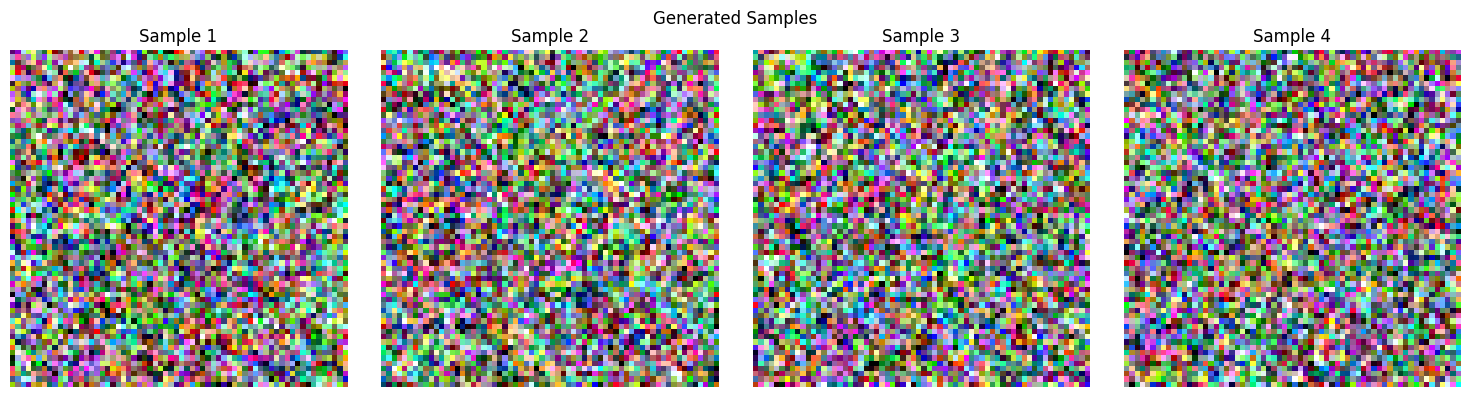

Training:  96%|█████████▌| 25/26 [00:15<00:01,  1.15s/it, Loss=0.1521]

--- Sampling complete ---



Epoch 9 completed. Average Loss: 0.1485
Epoch 10/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.1517]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.22step/s, Step=50/50]


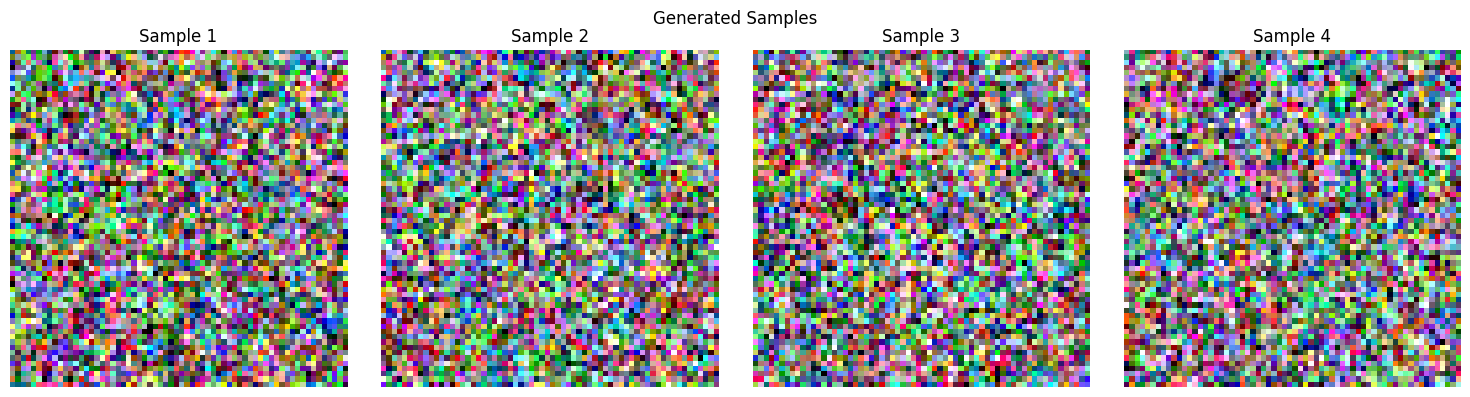

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1517]

--- Sampling complete ---



Epoch 10 completed. Average Loss: 0.1407
Epoch 11/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.1580]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.38step/s, Step=50/50]


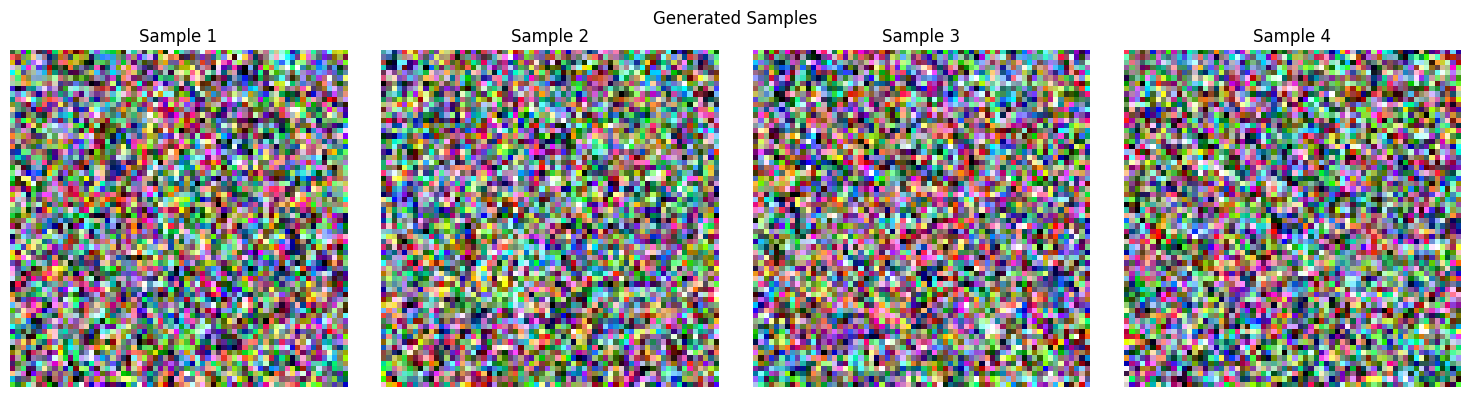

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1580]

--- Sampling complete ---



Epoch 11 completed. Average Loss: 0.1389
Epoch 12/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.91it/s, Loss=0.1295]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.09step/s, Step=50/50]


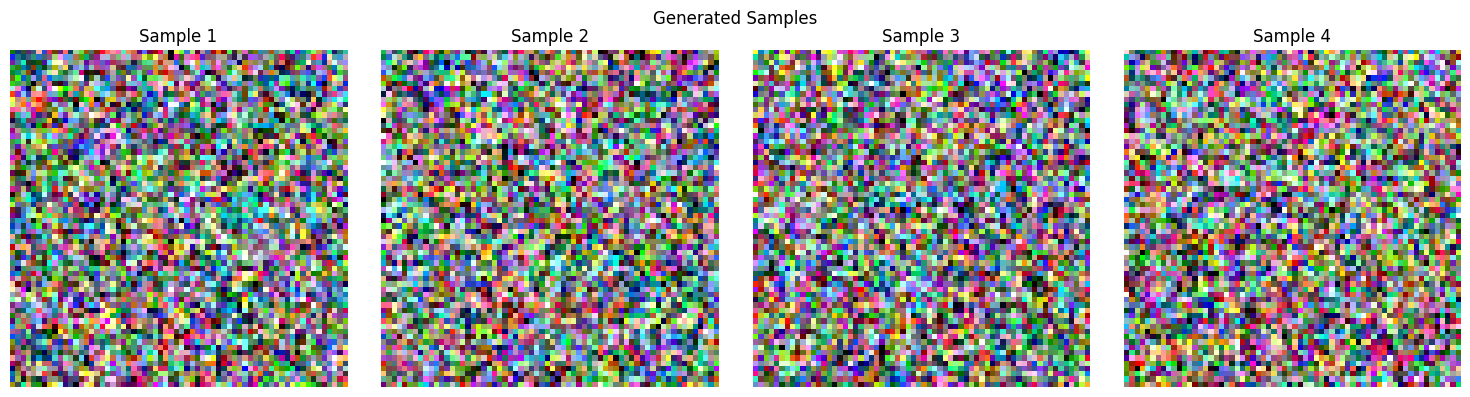

Training:  96%|█████████▌| 25/26 [00:15<00:01,  1.07s/it, Loss=0.1295]

--- Sampling complete ---



Epoch 12 completed. Average Loss: 0.1288
Epoch 13/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.1491]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.24step/s, Step=50/50]


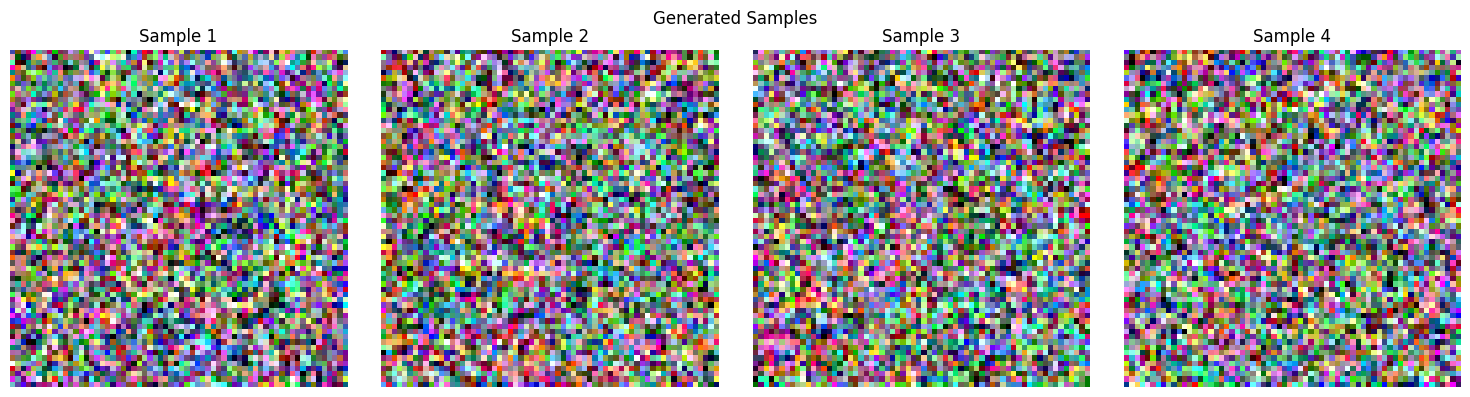

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1491]

--- Sampling complete ---



Epoch 13 completed. Average Loss: 0.1294
Epoch 14/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.91it/s, Loss=0.1381]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.28step/s, Step=50/50]


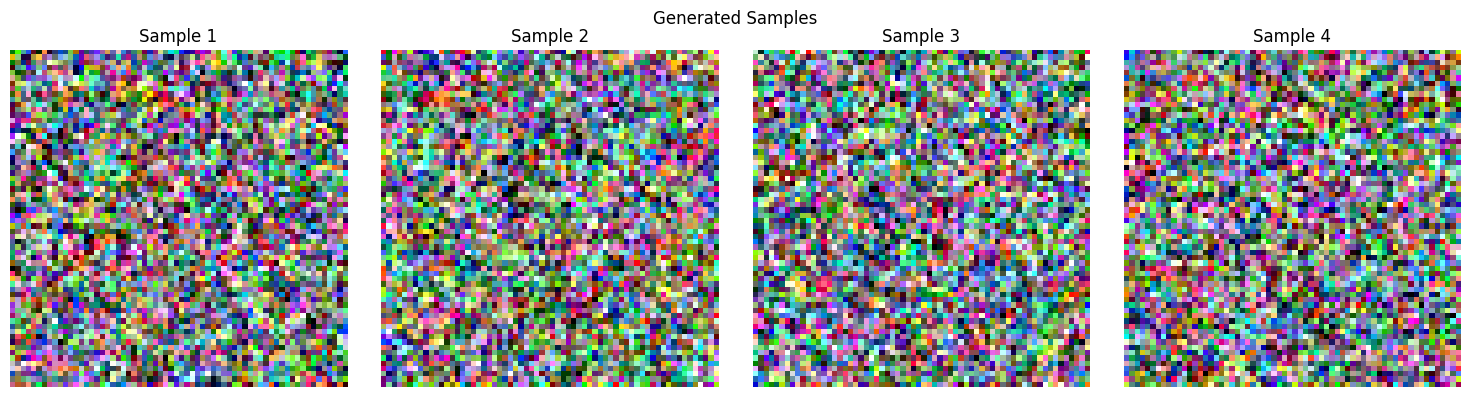

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1381]

--- Sampling complete ---



Epoch 14 completed. Average Loss: 0.1248
Epoch 15/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.1219]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.34step/s, Step=50/50]


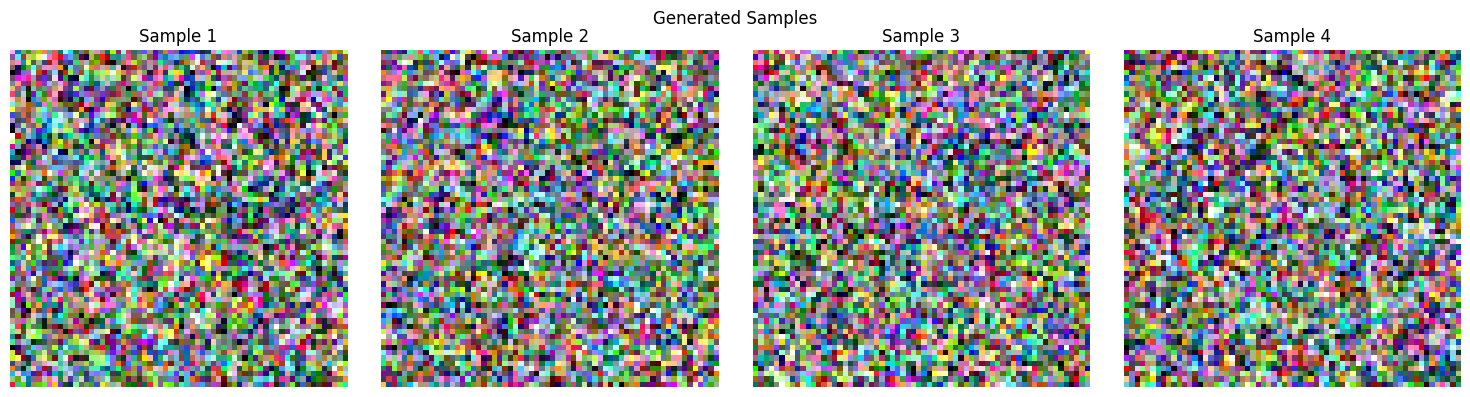

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1219]

--- Sampling complete ---



Epoch 15 completed. Average Loss: 0.1282
Epoch 16/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.1281]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.27step/s, Step=50/50]


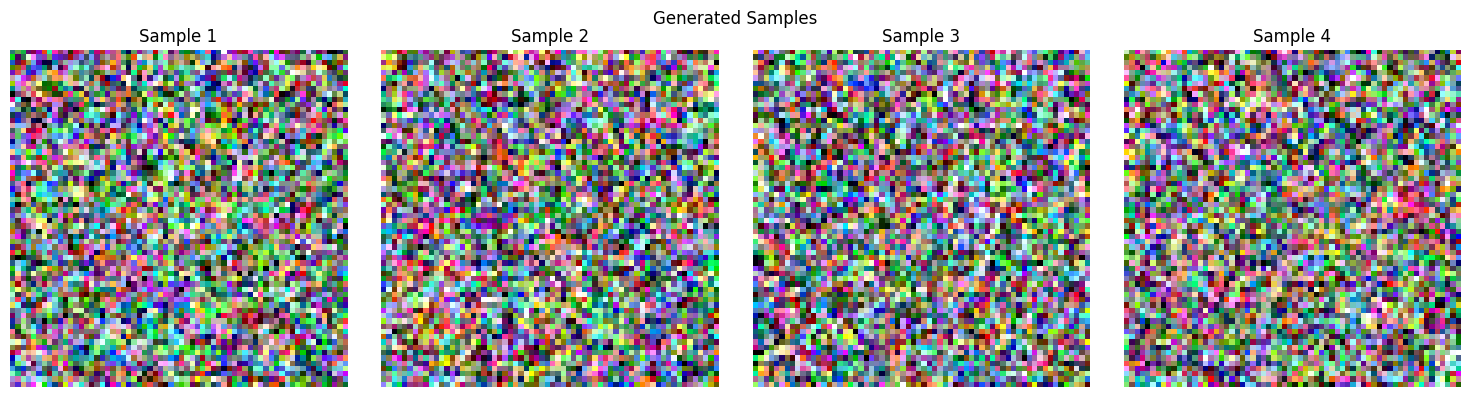

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1281]

--- Sampling complete ---



Epoch 16 completed. Average Loss: 0.1240
Epoch 17/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.91it/s, Loss=0.1071]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.29step/s, Step=50/50]


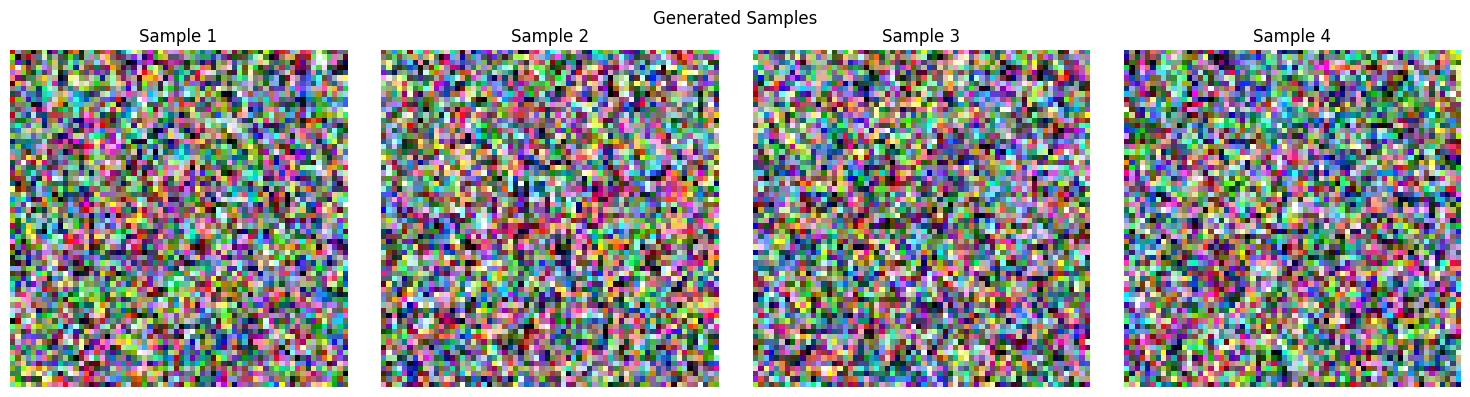

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1071]

--- Sampling complete ---



Epoch 17 completed. Average Loss: 0.1227
Epoch 18/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.91it/s, Loss=0.1071]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.27step/s, Step=50/50]


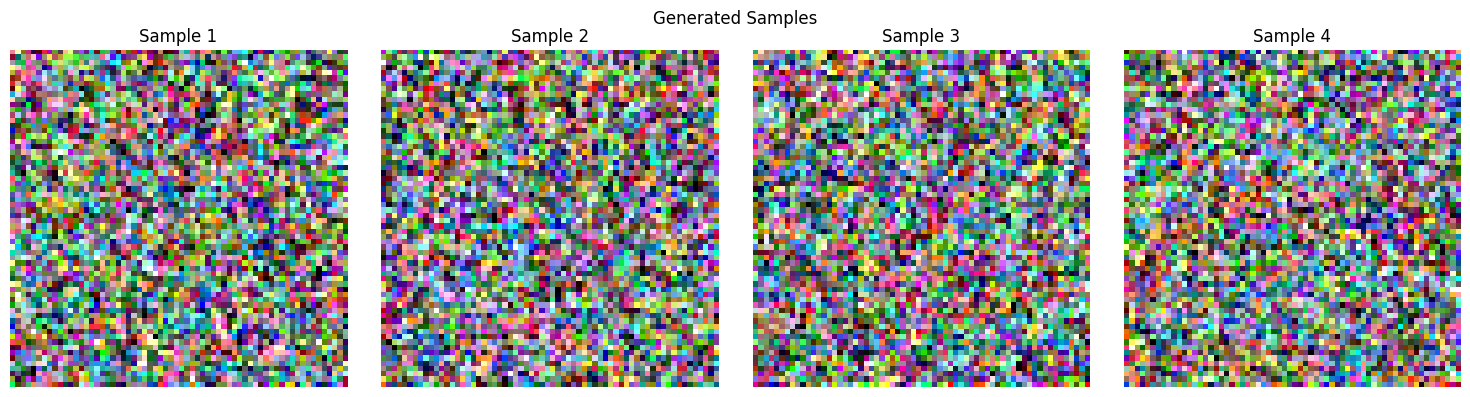

Training:  96%|█████████▌| 25/26 [00:15<00:01,  1.15s/it, Loss=0.1071]

--- Sampling complete ---



Epoch 18 completed. Average Loss: 0.1154
Epoch 19/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.1314]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.33step/s, Step=50/50]


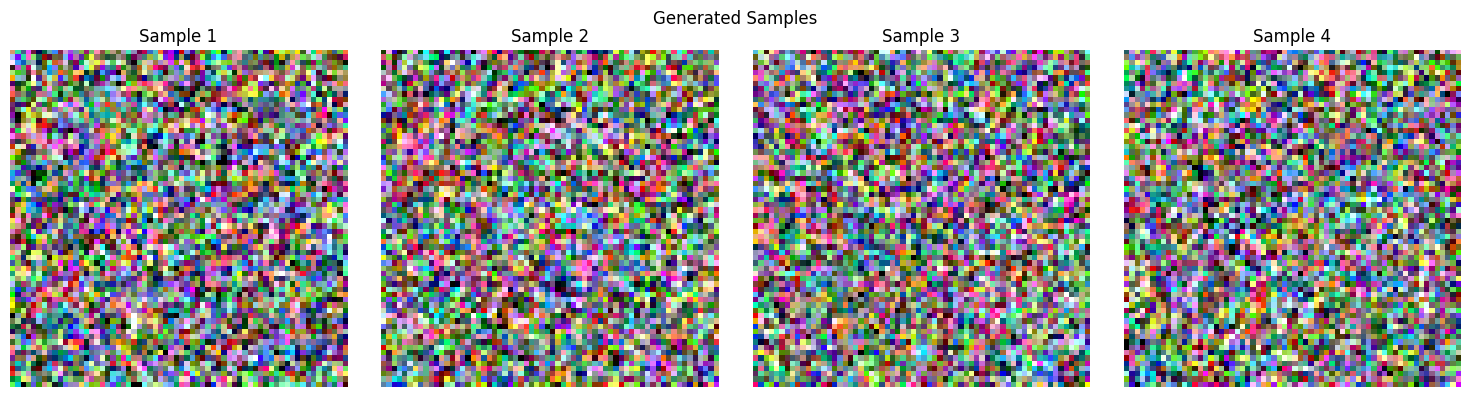

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1314]

--- Sampling complete ---



Epoch 19 completed. Average Loss: 0.1149
Epoch 20/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.1043]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.25step/s, Step=50/50]


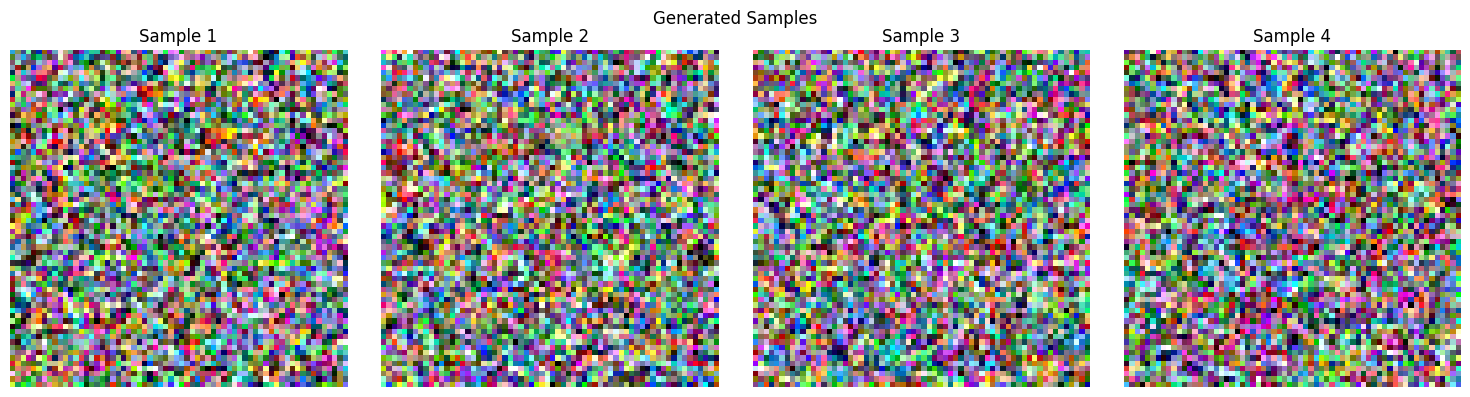

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.07s/it, Loss=0.1043]

--- Sampling complete ---



Epoch 20 completed. Average Loss: 0.1135
Epoch 21/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.1291]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.31step/s, Step=50/50]


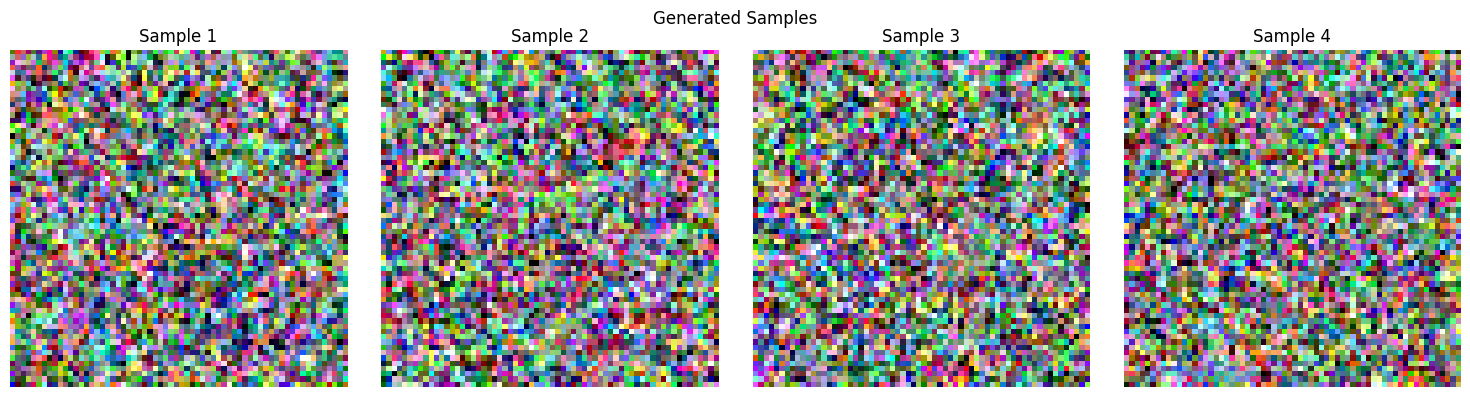

Training:  96%|█████████▌| 25/26 [00:15<00:01,  1.06s/it, Loss=0.1291]

--- Sampling complete ---



Epoch 21 completed. Average Loss: 0.1119
Epoch 22/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.91it/s, Loss=0.1320]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.28step/s, Step=50/50]


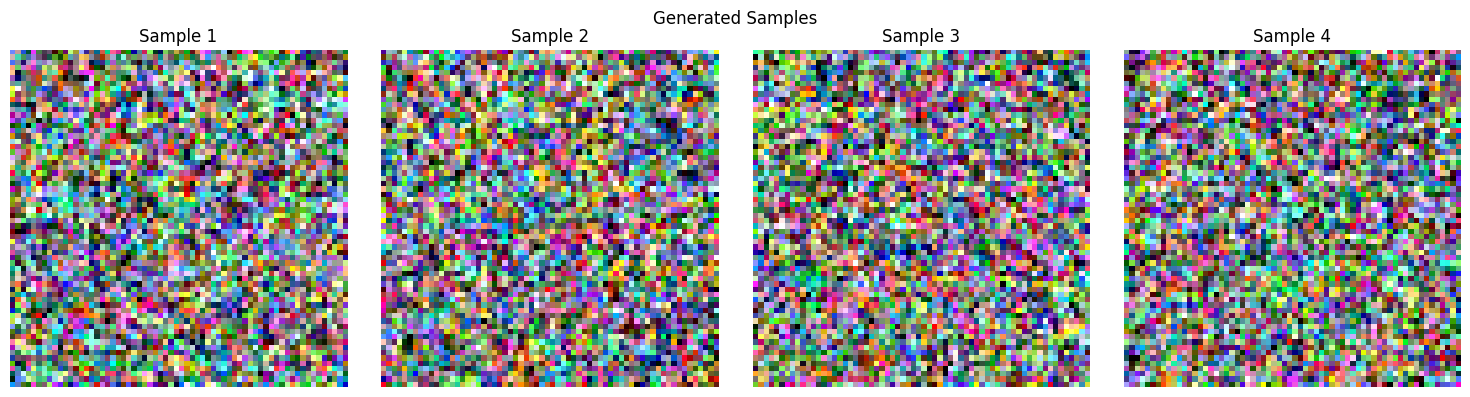

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1320]

--- Sampling complete ---



Epoch 22 completed. Average Loss: 0.1098
Epoch 23/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.92it/s, Loss=0.1130]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.18step/s, Step=50/50]


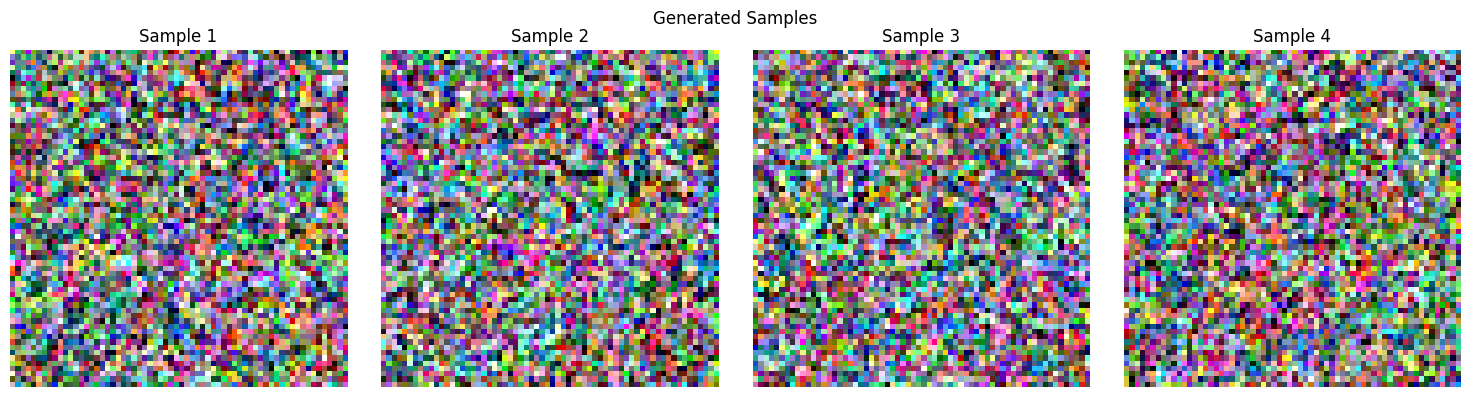

Training:  96%|█████████▌| 25/26 [00:15<00:01,  1.07s/it, Loss=0.1130]

--- Sampling complete ---



Epoch 23 completed. Average Loss: 0.1080
Epoch 24/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.91it/s, Loss=0.1117]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.24step/s, Step=50/50]


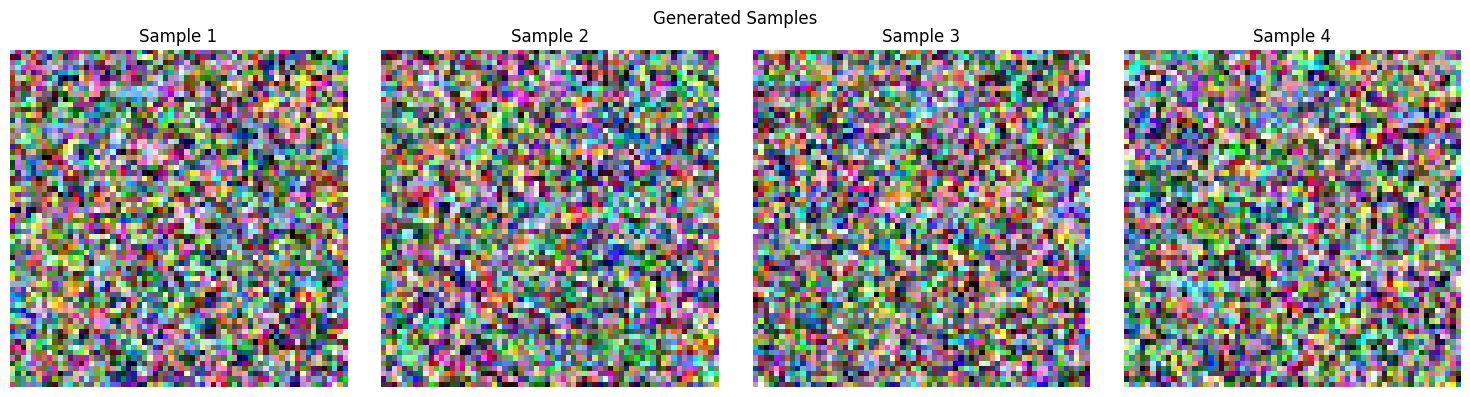

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1117]

--- Sampling complete ---



Epoch 24 completed. Average Loss: 0.1047
Epoch 25/25


Training:  92%|█████████▏| 24/26 [00:13<00:01,  1.91it/s, Loss=0.1117]


--- Sampling after batch 25 ---
Generating samples...


Denoising: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 33.25step/s, Step=50/50]


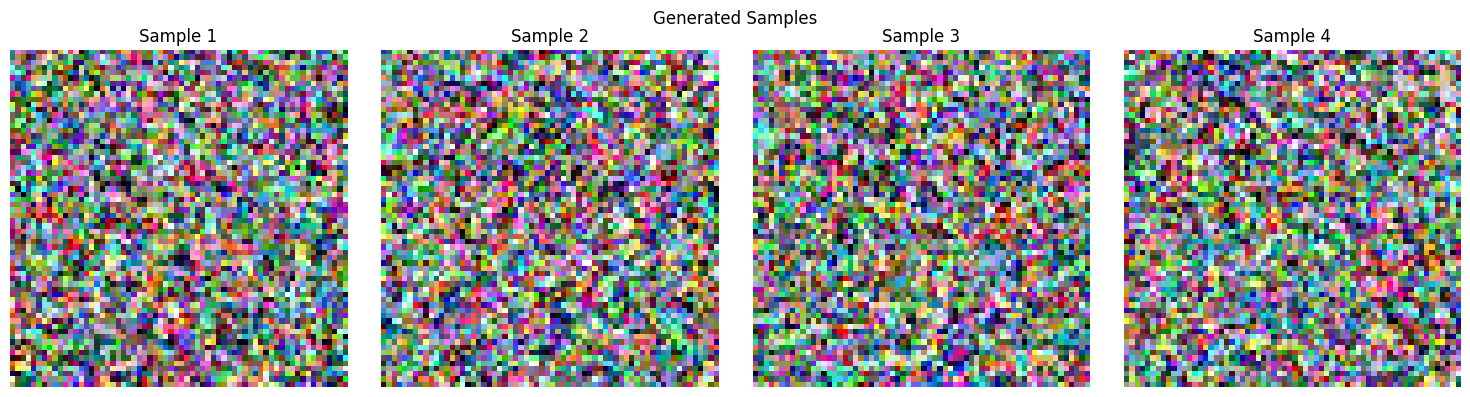

Training:  96%|█████████▌| 25/26 [00:14<00:01,  1.06s/it, Loss=0.1117]

--- Sampling complete ---



Epoch 25 completed. Average Loss: 0.1065

Training completed!


In [13]:
import torch.optim as optim
from tqdm import tqdm


# Hyperparameters
epochs = 25
learning_rate = 3e-4
num_batches = len(dataloader) # 26


# Initialize optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training function
def train_ddpm():
    model.train()
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_loss = 0
        
        # Progress bar for batches
        pbar = tqdm(enumerate(dataloader), leave=False, total=num_batches, desc=f"Training")
        
        for batch_idx, batch in pbar:
            # Move data to device
            clean_images = batch.to(device)
            batch_size = clean_images.shape[0]
            
            # Sample random timesteps for each image
            timesteps = torch.randint(0, sampler.num_training_steps, (batch_size,)).to(device)
            
            # Add noise to images
            noisy_images, actual_noise = sampler.add_noise(clean_images, timesteps)

            optimizer.zero_grad()             
            predicted_noise = model(noisy_images, timesteps)  # Forward pass - predict the noise
            loss = criterion(predicted_noise, actual_noise)  # Calculate loss
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Update metrics
            epoch_loss += loss.item()
            
            # Update progress bar
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
            
            # Sample every 5 batches
            if (batch_idx + 1) % 25 == 0:
                print(f"\n--- Sampling after batch {batch_idx + 1} ---")
                sample_images()
                print("--- Sampling complete ---\n")
        
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}")



# Sampling function for generating images
@torch.no_grad()
def sample_images(num_samples=4):
    model.eval()
    
    # Start with pure noise
    samples = torch.randn(num_samples, 3, 64, 64).to(device)
    
    # Reverse diffusion process (simplified - only 50 steps for speed)
    timesteps_to_sample = torch.linspace(99, 0, 50).long().to(device)
    
    print("Generating samples...")
    # Use leave=True and position=0 for in-place updates
    with tqdm(total=len(timesteps_to_sample), desc="Denoising", leave=True, 
              position=0, ncols=100, unit="step") as pbar:
        for i, timestep in enumerate(timesteps_to_sample):
            # Create timestep tensor for all samples
            t = torch.full((num_samples,), timestep.item()).to(device)
            
            # Predict noise
            predicted_noise = model(samples, t)
            
            # Remove noise (simplified version)
            if timestep > 0:
                # Get previous timestep
                prev_timestep = timesteps_to_sample[min(i + 1, len(timesteps_to_sample) - 1)]
                samples = sampler.remove_noise(samples, t, predicted_noise)

            # Update progress bar description with current step
            pbar.set_postfix({'Step': f'{i+1}/{len(timesteps_to_sample)}'})
            pbar.update(1)
    
    # Convert to displayable format
    samples = (samples + 1) / 2  # Convert from [-1, 1] to [0, 1]
    samples = torch.clamp(samples, 0, 1)
    
    # Display samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    for i in range(num_samples):
        img = samples[i].cpu().permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Sample {i+1}')
    
    plt.suptitle('Generated Samples')
    plt.tight_layout()
    plt.show()
    
    model.train()  # Set back to training mode



# Run training
print("Starting DDPM Training...")
print(f"Device: {device}")
print(f"Total batches per epoch: {num_batches}")
print(f"Sampling every 5 batches")
print("-" * 50)

train_ddpm()

print("\nTraining completed!")

# Optional: Generate final samples
# print("\nGenerating final samples...")
# sample_images(num_samples=6)

In [17]:
!kill -9 2862

/bin/bash: line 1: kill: (2862) - No such process


In [10]:
timesteps_to_sample = torch.linspace(99, 0, 50).long().to(device)
timesteps

[0, 25, 50, 75, 99]